In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import tensorflow as tf

In [2]:
imstack = np.load('tiles.npy', allow_pickle=True)
# imstack = imstack[...,np.newaxis]
print(imstack.shape)

(40400, 128, 128)


32 principal components explains 95% of variance


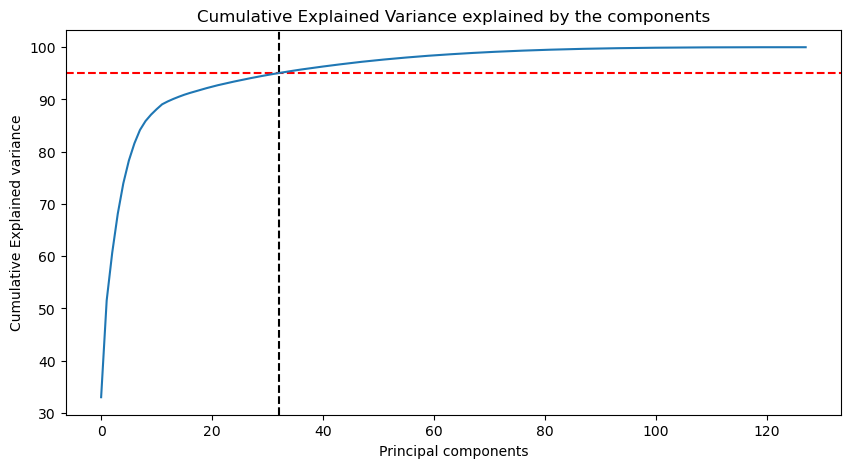

In [6]:
from sklearn.decomposition import PCA, IncrementalPCA
pca = PCA()
pca.fit(imstack[1])

# Getting the cumulative variance

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print(f"{k} principal components explains 95% of variance")
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

When looking at the first image of imstack, from 16384 pixels (128 x 128), **32** components can explain variance in the image. Lets see what the spread looks like throughout the entire top_view dataset. However, We must remember that PCA is a linear method and we would prefer to capture non-linear patterns in image data.

In [7]:
components = []
for im in range(len(imstack)):
    pca = PCA()
    pca.fit(imstack[im])
    
    var_cumu = np.cumsum(pca.explained_variance_ratio_)*100
    k = np.argmax(var_cumu > 95)
    components.append(k)

In [89]:
imstack_2d = np.array([img.flatten() for img in imstack])
pca = PCA(n_components=1000)
pca.fit(imstack_2d)

imstack2d_pca = pca.transform(imstack_2d)

In [90]:
pca.score_samples(imstack_2d)

array([52401.29 , 51535.61 , 50995.086, ..., 51749.664, 51203.91 ,
       51503.75 ], dtype=float32)

In [8]:
from pandas import DataFrame

df = DataFrame(components)
df = df.rename(columns={0:'K_components'})

In [91]:
df['K_components'].value_counts().head()

8     8374
7     6270
9     5295
10    3611
11    3298
Name: K_components, dtype: int64

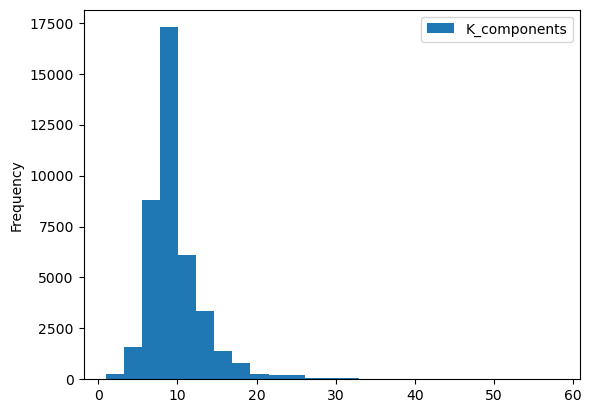

In [14]:
df.plot.hist(bins=25, grid=False).get_figure().savefig('K_components_explaining_variance.png')

From this PCA reduction, we find that the number of components (K) needed to explain the most important features can be explained of images in the *top_view* dataset is positively skewed around 8 (mode) / 9.7 (mean) for images of (128px by 128px) . Therefore, we could set the latent dimension to this reduced dimensionality.

<function matplotlib.pyplot.show(close=None, block=None)>

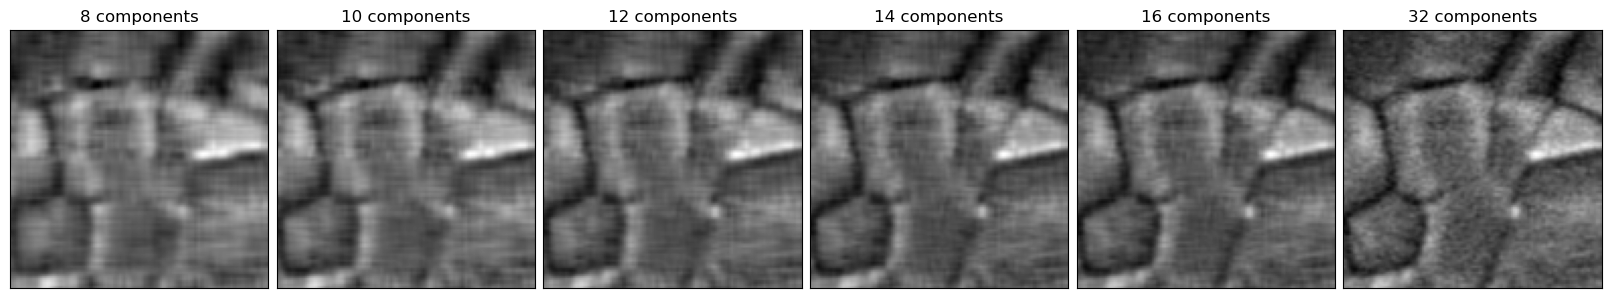

In [72]:
comp = [8,10,12,14,16,32]
# im = np.random.randint(0, len(imstack)-1)
# print(im)
im = 4636


plt.figure(figsize=(16, 6), layout="constrained")

for k in range(len(comp)):
    ipca = IncrementalPCA(n_components= comp[k])
    imstack_recon = ipca.inverse_transform(ipca.fit_transform(imstack[im]))
    
    # display original
#     ax = plt.subplot(2, len(comp), k + 1)
#     plt.title("original")
#     plt.imshow(tf.squeeze(imstack[im]))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
    #display reconstruction
    bx = plt.subplot(2, len(comp), k + len(comp) + 1)
    plt.title(f"{comp[k]} components")
    plt.imshow(imstack_recon)
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.savefig("pca_reconstruction.png")
plt.show

Using PCA, we can see the effect of increasing the number of components with image reconstruction. At the lower end, the loss in quality is high and increases with added components. Contrarily, on the higher end, there is visually little difference reconstructed images. So we can assume that a good latent space dimension for the VAE would be around 12, not 8/9.

Inspiration from:

- https://www.kaggle.com/code/mirzarahim/introduction-to-pca-image-compression-example
- https://www.kaggle.com/code/hamishdickson/preprocessing-images-with-dimensionality-reduction
- https://www.tensorflow.org/tutorials/generative/autoencoder#second_example_image_denoising